### Introduction

LendingTree is an online lending exchange that connects consumers with multiple lenders, banks, and credit partners who compete for business. LendingTree is not a direct supplier of loans; it is instead a broker. We will be working with LendingTree’s data to explore one of the oldest prediction problems – predicting risk on consumer loans.

This notebook is used to:
* Develop a statistical model for predicting bad loans
* Use the model to identify the most important drivers of bad loans
* Make recommendations to avoid funding bad loans.

### Business Problem

Being as a broker, playing a role as the connection between the borrowers and lenders, there are many times a broker would like to have an overview of whether a loan can be approved by lenders or not. As a result, basing on the dataset collected by **LendingTree**, we can find out the important features affecting a loan and can foresee the chance of a loan to be approved.

### Explore the dataset

First, we need to read the dataset

In [82]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # this is used for the plot the graph 
import numpy as np
%matplotlib inline

In [83]:
full_data = pd.read_csv("loan_data.csv", skiprows=1)

Then, let's see what kind of data we have in the dataset by list out all of the columns in the dataset

In [57]:
columns = list(full_data.columns.values)
print "Columns size:", len(columns)
columns

Columns size: 145


['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

In all of these columns, the outcome (what we want to predict) is the column called **grade**. It is the **Loan grade**. Based on each loan application and credit report, every loan is assigned a grade ranging from A1 to E5. 

We will ignore the column **sub_grade** because basing on only grade, we can evaluate a loan.

In [84]:
full_data.drop(['sub_grade'], axis=1, inplace=True)
outcome = full_data[['grade']]
outcome.head(5)

,grade
0,B
1,B
2,C
3,E
4,C


Let's see how many grade we have to evaluate

In [85]:
outcome['grade'].unique()

array(['B', 'C', 'E', 'A', 'D', 'G', 'F', nan], dtype=object)

There are two things we need to do with the outcome dataset:
* We have _nan_ value in our dataset, so we will drop all the row having the _nan_ value. 
* We need to transform all the outcome data into number so the model can understand it.

In [86]:
full_data = full_data[pd.notnull(full_data['grade'])]
map_grade = {"A":1,"B":2,"C":3,"D":4,"E":5,"F":6}
full_data["grade"] = full_data["grade"].map(map_grade)
full_data['grade'].head(5)

0    2.0
1    2.0
2    3.0
3    5.0
4    3.0
Name: grade, dtype: float64

### Clean up the dataset

We remove all the data indicating id because it is unique for every row. The column **url** and **desc** are empty for all rows, we should remove them too. Moreover, all the information that a borrower can give out by himself/herself should be remove because the model is built to help the borrowers evaluate their ability for a loan.

In [87]:
full_data.drop(['id', 'member_id', 'url', 'desc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
               'title', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_record',
               'open_acc', 'pub_rec', 'total_acc', 'initial_list_status', 'recoveries', 'collection_recovery_fee',
               'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code',
               'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'revol_bal_joint', 'payment_plan_start_date',
               'debt_settlement_flag_date', 'settlement_date','verification_status_joint'], axis=1, inplace=True)

As we can see, now all the data relating to **grade** are transformed to number only. We have finished correct the outcome dataset. Now we need to cleanup uncessary data because we have **145** columns in total and we do not want to have useless features in our model.

All the information relates to the loan after being funded is not considered too.

In [88]:
full_data.drop(['funded_amnt_inv', 'funded_amnt', 'out_prncp', 
               'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
               'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt', 'last_pymnt_d', 'next_pymnt_d',
               'last_credit_pull_d'], axis=1, inplace=True)

After cleaning up uncessary, let's see how many columns we have in the dataset.

In [89]:
columns = list(full_data.columns.values)
print "Columns size:", len(columns)
columns

Columns size: 103


['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'mths_since_last_delinq',
 'revol_bal',
 'revol_util',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'n

The **int_rate** is Interest Rate on the loan. It is decided based on the grade of the loan so we do not need this information too.
The **installment** describes the monthly payment owed by the borrower if the loan originates. This information is not necessary but basing on this information, I introduce a new column called **ability_to_pay**. This column contains only two value 0 and 1. **0** indicates that the borrower's monthly income is lower than the amount thay have to pay each month. **1** indicates that the borrower's monthly income is higher than the amount thay have to pay each month.

In [90]:
full_data.drop(['int_rate'], axis=1, inplace=True)
def ableToPay(annualInc, installment):
    monthInc = annualInc / 12
    if (monthInc >= installment):
        return 1
    else:
        return 0
    
full_data['ability_to_pay'] = full_data.apply(lambda row: ableToPay(row['annual_inc'], row['installment']), axis=1)
full_data.drop(['installment'], axis=1, inplace=True)

In [91]:
full_data['term'].head(5)

0     36 months
1     60 months
2     36 months
3     36 months
4     36 months
Name: term, dtype: object

Next step, we will transform all categorical data into numbers because our model only understands numbers.

In [95]:
full_data['emp_length'].unique()

array(['4 years', '10+ years', '1 year', '3 years', '8 years', 'nan',
       '6 years', '< 1 year', '9 years', '5 years', '2 years', '7 years'],
      dtype=object)

In [96]:
def convertEmploymentLength(l):
    if l == '< 1 year' or l == 'nan':
        return 0
    if l == '10+ years':
        return 10
    if l[1] == ' ':
        return (int)(l[:2])
    return (int)(l[:3])

def convert(data, listValue):
    return listValue.index(data)

def transformCategoricalData(df):
    result = df.copy()
    listPurpose = list(df['purpose'].unique())
    print "Purpose", listPurpose
    listOwnership = list(df['home_ownership'].unique())
    print "Ownership", listOwnership
    listAppType = list(df['application_type'].unique())
    print "Application Type", listAppType
    listHardshipFlag = list(df['hardship_flag'].unique())
    print "Hardship", listHardshipFlag
    listHSLoanStatus = list(df['hardship_loan_status'].unique())
    print "Hardship Loan Status", listHSLoanStatus
    listDisbursement = list(df['disbursement_method'].unique())
    print "Disbursement", listDisbursement
    listDebtFlag = list(df['debt_settlement_flag'].unique())
    print "Debt Settlement", listDebtFlag
    for index, row in result.iterrows():
        result.at[index, 'emp_length'] = convertEmploymentLength(row['emp_length'])
        result.at[index, 'purpose'] = convert(row.purpose, listPurpose)
        result.at[index, 'home_ownership'] = convert(row['home_ownership'], listOwnership)
        result.at[index, 'application_type'] = convert(row['application_type'], listAppType)
        result.at[index, 'hardship_flag'] = convert(row['hardship_flag'], listHardshipFlag)
        result.at[index, 'hardship_loan_status'] = convert(row['hardship_loan_status'], listHSLoanStatus)
        result.at[index, 'disbursement_method'] = convert(row['disbursement_method'], listDisbursement)
        result.at[index, 'debt_settlement_flag'] = convert(row['debt_settlement_flag'], listDebtFlag)
    return result

In [97]:
full_data['term'] = full_data['term'].apply(lambda x: x.lstrip())
full_data['emp_length'] = full_data['emp_length'].astype('str') 
full_data = transformCategoricalData(full_data)
full_data.head(5)

Purpose ['credit_card', 'debt_consolidation', 'car', 'major_purchase', 'other', 'home_improvement', 'medical', 'vacation', 'small_business', 'house', 'moving', 'renewable_energy']
Ownership ['RENT', 'MORTGAGE', 'OWN', 'ANY', 'NONE']
Application Type ['Individual', 'Joint App']
Hardship ['N', 'Y']
Hardship Loan Status [nan, 'Late (16-30 days)', 'Current', 'In Grace Period', 'Late (31-120 days)']
Disbursement ['Cash', 'DirectPay']
Debt Settlement ['N', 'Y']


,loan_amnt,term,grade,emp_title,emp_length,home_ownership,annual_inc,purpose,zip_code,addr_state,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,settlement_status,settlement_amount,settlement_percentage,settlement_term,ability_to_pay
0,4600.0,36 months,2.0,cable technician,4,0,44470.0,0,066xx,CT,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,1
1,15400.0,60 months,2.0,Social worker,10,1,95000.0,1,068xx,CT,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,1
2,14000.0,36 months,3.0,Project Leader,10,1,82000.0,0,672xx,KS,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,1
3,5000.0,36 months,5.0,Pilot,10,1,215000.0,1,067xx,CT,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,1
4,4700.0,36 months,3.0,RN Manager,10,1,100046.0,1,847xx,UT,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,1


After transforming all of categorical data, I figure out some more columns that we need to remove because it just give more details about other columns.

In [98]:
full_data.drop(['emp_title', 'settlement_status','hardship_loan_status', 'hardship_dpd',
               'hardship_end_date', 'hardship_start_date', 'deferral_term', 'hardship_status', 'zip_code', ], axis=1, inplace=True)

As we can see, we still have some number data having **NAN** value. We will replace all **NAN** by **-1** for these number datas.

In [99]:
full_data.replace('n/a', np.nan,inplace=True)
full_data.fillna(value=-1,inplace=True)
full_data.head(5)

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,...,hardship_length,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,settlement_amount,settlement_percentage,settlement_term,ability_to_pay
0,4600.0,36 months,2.0,4,0,44470.0,0,CT,13.43,0.0,...,-1.0,-1.0,-1.0,-1.0,0,0,-1.0,-1.0,-1.0,1
1,15400.0,60 months,2.0,10,1,95000.0,1,CT,11.52,0.0,...,-1.0,-1.0,-1.0,-1.0,0,0,-1.0,-1.0,-1.0,1
2,14000.0,36 months,3.0,10,1,82000.0,0,KS,31.07,0.0,...,-1.0,-1.0,-1.0,-1.0,0,0,-1.0,-1.0,-1.0,1
3,5000.0,36 months,5.0,10,1,215000.0,1,CT,6.06,0.0,...,-1.0,-1.0,-1.0,-1.0,0,0,-1.0,-1.0,-1.0,1
4,4700.0,36 months,3.0,10,1,100046.0,1,UT,12.37,1.0,...,-1.0,-1.0,-1.0,-1.0,0,0,-1.0,-1.0,-1.0,1


Now, our dataset is clean. Let's do some data visualization so that we could remove some other features before putting them into the model.

### Data Visualization and Analysis

Let's see the number of loan of each grade

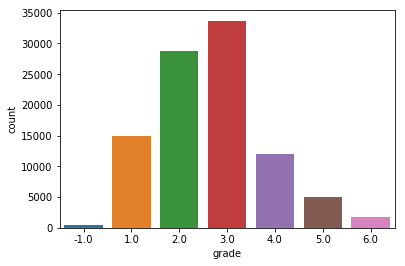

In [92]:
sb.countplot(full_data['grade'],label="Count")

Now, let's see some relation of some features. The quality of a loan can be decided by some basic features such as **Loan amount**, **Application Type**, **Income**, **Loan Term**, **Home Ownership**, **Loan Purpose**, **Employment Time**, **DTI**, **Harship**, **Disbursement Method** and **Debt Settlement**. We will include these features in our model.

Because we have a lot of features, we need to know how much features we should put into our model. To do that, I will try two method for feature selection. First, we will use correlation of each feature and will try to put each feature into the model.
    

In [284]:
columns = list(full_data.columns.values)
columns.remove('grade')
list_feature = {}
for col in columns:
    if full_data[col].dtype == 'object':
        continue
    correlation = full_data['grade'].corr(full_data[col])
    if correlation != 0:
        list_feature[abs(correlation)] = col

list_feature

{5.816378603886334e-05: 'num_op_rev_tl',
 0.0006651538136063565: 'sec_app_num_rev_accts',
 0.0019799704296672494: 'sec_app_mort_acc',
 0.003689386606629633: 'delinq_amnt',
 0.003938993102519349: 'sec_app_chargeoff_within_12_mths',
 0.004058902278425538: 'ability_to_pay',
 0.004218386489592983: 'tot_coll_amt',
 0.004360475303914246: 'acc_now_delinq',
 0.004582047412804649: 'num_tl_30dpd',
 0.0053520724305904065: 'sec_app_open_acc',
 0.0063233927034576235: 'sec_app_collections_12_mths_ex_med',
 0.008005014983872103: 'total_bal_il',
 0.008119487624415557: 'sec_app_open_act_il',
 0.008321262694138602: 'total_cu_tl',
 0.008965505593643444: 'chargeoff_within_12_mths',
 0.009968821446251809: 'annual_inc_joint',
 0.010102282954338588: 'sec_app_inq_last_6mths',
 0.011474668620340774: 'sec_app_mths_since_last_major_derog',
 0.012160787468520756: 'sec_app_revol_util',
 0.012446854216667982: 'open_act_il',
 0.012644785327458124: 'hardship_flag',
 0.012819379718840746: 'mths_since_recent_revol_deli

Now we have a list of correlation of each feature. Now we need to sort this list descending so we always try the best correlation first.

In [285]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def calculateAccuracy(features, data):
    X = pd.DataFrame(data, columns=features)
    y = data['grade']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    logistic = LogisticRegression()
    logistic.fit(X_train, y_train)
    return accuracy_score(y_test, logistic.predict(X_test))

In [286]:
correlation = list_feature.keys()
correlation.sort(reverse=True)

test_list_feature = [list_feature[x] for x in correlation[:10]]
results_LR = []
test_data = full_data.head(5000)
for i in range(11, len(correlation)):
    test_list_feature.append(list_feature[correlation[i]])
    results_LR.append(calculateAccuracy(test_list_feature, test_data))


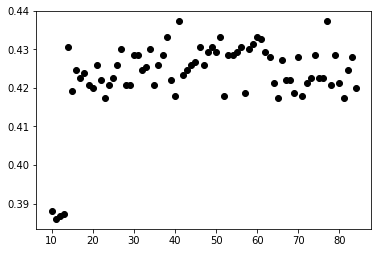

In [290]:
x = range(10, 85)
y = results_LR
plt.plot(x, y, 'o', color='black');